### Machine Learning Engineer Capstone Project 

## Project: Dog Identification App 

In this notebook, I will develop an algorithm to estimate the dog's breed. This algorithm will be composed by a dog detector and a human detector. If a dog is detected in the input image, it will provide an estimate of the dog's breed. If a human is detected, it will provide an estimate of the dog breed that is most similar.

### Roadmap

* [First](#step1):  Import Datasets 
* [Second](#step2): Transform the data
* [Third](#step3):  Implement dog detector
* [Fourth](#step4): Implement human detector
* [Fifth](#step5):  Implement dog breed estimator

<a id='step1'></a>

## 1<sup>st</sup>: Import datasets

The datasets that I will use are obtain from:
* [Standford database for dog breeds images](https://www.kaggle.com/c/7327/download-all) dataset from kaggle competition
* the human images from "[Labeled Faced in the Wild](http://vis-www.cs.umass.edu/lfw/)".

For dog-breed dataset, I will download the zip for the kaggle competition that gives us the data divided in train and test. The zip file will be upload to the jupiter notebook repository and then I must unzip the file.

In [19]:
!wget http://vision.stanford.edu/aditya86/ImageNetDogs/images.tar
!wget http://vision.stanford.edu/aditya86/ImageNetDogs/annotation.tar

--2020-01-14 21:04:13--  http://vision.stanford.edu/aditya86/ImageNetDogs/images.tar
Resolving vision.stanford.edu (vision.stanford.edu)... 171.64.68.10
Connecting to vision.stanford.edu (vision.stanford.edu)|171.64.68.10|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 793579520 (757M) [application/x-tar]
Saving to: ‘images.tar’

images.tar          100%[===================>] 756.82M  24.8MB/s    in 32s     

2020-01-14 21:04:45 (23.6 MB/s) - ‘images.tar’ saved [793579520/793579520]

--2020-01-14 21:04:45--  http://vision.stanford.edu/aditya86/ImageNetDogs/annotation.tar
Resolving vision.stanford.edu (vision.stanford.edu)... 171.64.68.10
Connecting to vision.stanford.edu (vision.stanford.edu)|171.64.68.10|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 21852160 (21M) [application/x-tar]
Saving to: ‘annotation.tar.1’

annotation.tar.1    100%[===================>]  20.84M  10.4MB/s    in 2.0s    

2020-01-14 21:04:47 (10.4 MB/s) - ‘annot

In [20]:
!mkdir dogs_data
!mkdir dogs_data/generated
!tar -xf images.tar -C dogs_data/
!tar -xf annotation.tar -C dogs_data/

mkdir: cannot create directory ‘dogs_data’: File exists


Now I import all the libraries necessary in the notebook

For the Human datasets, I will use the sklearn datasets facilities.

In [ ]:
from sklearn.datasets import fetch_lfw_people

In [2]:
lfw_people = fetch_lfw_people(min_faces_per_person=2)

## 2<sup>nd</sup>: Transform the data

In this section, we will transform the dog dataset because we need the right tensors for input for the pre-trained models that I will use in the detectors

In [3]:
import numpy as np

from PIL import Image

import torchvision.transforms as transforms
import torchvision.models as models

import matplotlib.pyplot as plt
import torch

import os
from xml.dom import minidom
import json

First I make a dicti

In [4]:
dogs_categories = {}
category_counter = 0
for name in os.listdir("./dogs_data/Annotation"): 
    if os.path.isdir("./dogs_data/Annotation/"+name):
        dogs_categories[name[10:]] = category_counter
        category_counter += 1

In [34]:
for directory in os.listdir("./dogs_data/Annotation"): 
    annotation_directory = "./dogs_data/Annotation/"+directory
    if os.path.isdir(annotation_directory):
        print(annotation_directory)
        for file in os.listdir(annotation_directory):
            if os.path.isfile(annotation_directory+"/"+file):
                # parse an xml file by name
                mydoc = minidom.parse(annotation_directory+"/"+file)
                fileName =file
                jsonFile = fileName +'.json'
                line = {}
                line['file'] = "./dogs_data/Images/"+directory+"/"+fileName+".jpg"
                line['image_size'] = [{
                    'width':int(mydoc.getElementsByTagName('width')[0].firstChild.data),
                    'height':int(mydoc.getElementsByTagName('height')[0].firstChild.data),
                    'depth':mydoc.getElementsByTagName('depth')[0].firstChild.data
                }]
                line['annotations'] = []
                for box in mydoc.getElementsByTagName('bndbox'):
                    line['annotations'].append({
                        'class_id':int(dogs_categories[mydoc.getElementsByTagName('name')[0].firstChild.data]),
                        'top':int(mydoc.getElementsByTagName('bndbox')[0].childNodes[1].firstChild.data),
                        'left':int(mydoc.getElementsByTagName('bndbox')[0].childNodes[3].firstChild.data),
                        'width':int(mydoc.getElementsByTagName('bndbox')[0].childNodes[5].firstChild.data),
                        'height':int(mydoc.getElementsByTagName('bndbox')[0].childNodes[7].firstChild.data)})
                line['categories']=[]
                line['categories'].append({
                    'class_id':int(dogs_categories[mydoc.getElementsByTagName('name')[0].firstChild.data]),
                    'name':mydoc.getElementsByTagName('name')[0].firstChild.data
                })
                if line['annotations']:
                    with open(os.path.join('./dogs_data/generated', jsonFile),'w') as p:
                        json.dump(line,p)
      

./dogs_data/Annotation/n02086646-Blenheim_spaniel
./dogs_data/Annotation/n02087394-Rhodesian_ridgeback
./dogs_data/Annotation/n02092339-Weimaraner
./dogs_data/Annotation/n02112018-Pomeranian
./dogs_data/Annotation/n02097130-giant_schnauzer
./dogs_data/Annotation/n02098286-West_Highland_white_terrier
./dogs_data/Annotation/n02096051-Airedale
./dogs_data/Annotation/n02113712-miniature_poodle
./dogs_data/Annotation/n02096437-Dandie_Dinmont
./dogs_data/Annotation/n02085782-Japanese_spaniel
./dogs_data/Annotation/n02108089-boxer
./dogs_data/Annotation/n02093859-Kerry_blue_terrier
./dogs_data/Annotation/n02110063-malamute
./dogs_data/Annotation/n02097209-standard_schnauzer
./dogs_data/Annotation/n02105855-Shetland_sheepdog
./dogs_data/Annotation/n02090721-Irish_wolfhound
./dogs_data/Annotation/n02094258-Norwich_terrier
./dogs_data/Annotation/n02100877-Irish_setter
./dogs_data/Annotation/n02099429-curly-coated_retriever
./dogs_data/Annotation/n02095889-Sealyham_terrier
./dogs_data/Annotation/

In [ ]:
def image_to_tensor(img_path):
    '''
    From Pytorch documentation:
    The Pytorch pre-trained models expects inputs images normalized 3-channels RGB images of shape (3 x H x W),
    where H and W are expected to be at least 224. 
    The images have to be loaded in to a range of [0, 1] and 
    then normalized using mean = [0.485, 0.456, 0.406] and std = [0.229, 0.224, 0.225]. 
    '''
    img = Image.open(img_path).convert('RGB')
    transformations = transforms.Compose([transforms.Resize(size=224),
                                          transforms.CenterCrop((224,224)),
                                         transforms.ToTensor(),
                                         transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                              std=[0.229, 0.224, 0.225])])
    image_tensor = transformations(img)[:3,:,:].unsqueeze(0)
    return image_tensor

def im_convert(tensor):
    """ Display a tensor as an image. """
    
    image = tensor.to("cpu").clone().detach()
    image = image.numpy().squeeze()
    image = image.transpose(1,2,0)
    image = image * np.array((0.229, 0.224, 0.225)) + np.array((0.485, 0.456, 0.406))
    image = image.clip(0, 1)

    return image

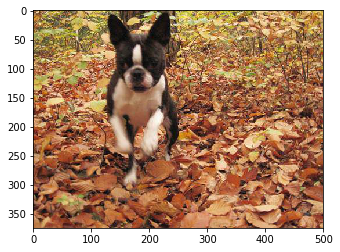

In [10]:
dog_image = Image.open('./dog_breed/train/000bec180eb18c7604dcecc8fe0dba07.jpg')
plt.imshow(dog_image)
plt.show()

torch.Size([1, 3, 224, 224])


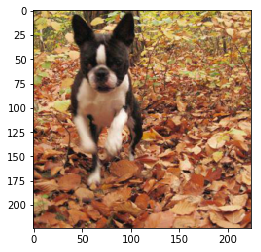

In [19]:
test_tensor = image_to_tensor('./dog_breed/train/000bec180eb18c7604dcecc8fe0dba07.jpg')
print(test_tensor.shape)
plt.imshow(im_convert(test_tensor))

## 3<sup>rd</sup>: Implement Dog Detector

For dog detector I will use an Sagemaker [image detector algorithm](https://docs.aws.amazon.com/sagemaker/latest/dg/object-detection.html).

In [25]:
%%time
import sagemaker
from sagemaker import get_execution_role

role = get_execution_role()
print(role)
sess = sagemaker.Session()

arn:aws:iam::491576157094:role/service-role/AmazonSageMaker-ExecutionRole-20191208T094449
CPU times: user 603 ms, sys: 63 ms, total: 666 ms
Wall time: 3.32 s


In [26]:
from sagemaker.amazon.amazon_estimator import get_image_uri

bucket = 'dog_breed_identification' # my bucket name
prefix = 'Dog Detection'

training_image = get_image_uri(sess.boto_region_name, 'dog-detection', repo_version="latest")
print (training_image)

825641698319.dkr.ecr.us-east-2.amazonaws.com/object-detection:latest
